In [1]:
import os
import tensorflow as tf
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import get_dataset_colormap
import cv2

In [2]:
tf.__version__

'1.12.0'

In [3]:
###  COPY ALL THE CODE INTO A JYPYTER NOTEBOOK  ### 
###  THE JYPYTER NOTEBOOK NEEDS TO BE IN 'tensorflow\models\research\deeplab'  ### 

## Imports

import collections
import os
import io
import sys
import tarfile
import tempfile
import urllib

from IPython import display
from ipywidgets import interact
from ipywidgets import interactive
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf

# Needed to show segmentation colormap labels
sys.path.append('utils')
import get_dataset_colormap


## Select and download models

_MODEL_URLS = {
    'xception_coco_voctrainaug': 'http://download.tensorflow.org/models/deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval': 'http://download.tensorflow.org/models/deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}

Config = collections.namedtuple('Config', 'model_url, model_dir')

def get_config(model_name, model_dir):
    return Config(_MODEL_URLS[model_name], model_dir)

config_widget = interactive(get_config, model_name=_MODEL_URLS.keys(), model_dir='')
display.display(config_widget)

# Check configuration and download the model

_TARBALL_NAME = 'deeplab_model.tar.gz'

config = config_widget.result

model_dir = config.model_dir or tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model to %s, this might take a while...' % download_path)
urllib.request.urlretrieve(config.model_url, download_path)
print('download completed!')


## Load model in TensorFlow

_FROZEN_GRAPH_NAME = 'frozen_inference_graph'


class DeepLabModel(object):
    """Class to load deeplab model and run inference."""
    
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513

    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()
        
        graph_def = None
        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if _FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break

        tar_file.close()
        
        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():      
            tf.import_graph_def(graph_def, name='')
        
        self.sess = tf.Session(graph=self.graph)
            
    def run(self, image):
        """Runs inference on a single image.
        
        Args:
            image: A PIL.Image object, raw input image.
            
        Returns:
            resized_image: RGB image resized from original input image.
            seg_map: Segmentation map of `resized_image`.
        """
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]
        return resized_image, seg_map

model = DeepLabModel(download_path)


## Helper methods

LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog',
    'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
    'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = get_dataset_colormap.label_to_color_image(FULL_LABEL_MAP)


def vis_segmentation(image, seg_map):
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')
    
    plt.subplot(grid_spec[1])
    seg_image = get_dataset_colormap.label_to_color_image(
        seg_map, get_dataset_colormap.get_pascal_name()).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')
    
    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0)
    
    plt.show()

## Run on sample images

# Note that we are using single scale inference in the demo for fast
# computation, so the results may slightly differ from the visualizations
# in README, which uses multi-scale and left-right flipped inputs.


interactive(children=(Dropdown(description='model_name', options=('xception_coco_voctrainaug', 'xception_coco_…

downloading model to /tmp/tmpxnx8wg7j/deeplab_model.tar.gz, this might take a while...
download completed!


running deeplab on image output.jpg...


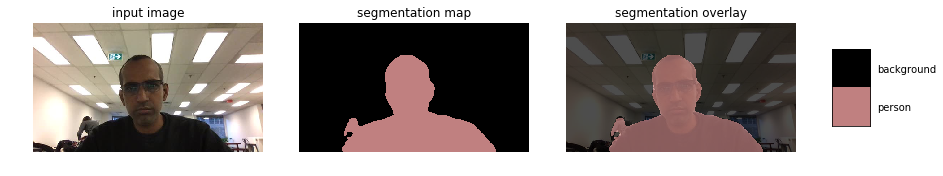

In [4]:
def run_demo_image(image_name):
    try:
        orignal_im = Image.open(image_name)
    except IOError:
        print('Failed to read image from %s.' % image_path)
        return 
    print('running deeplab on image %s...' % image_name)
    resized_im, seg_map = model.run(orignal_im)
    
    vis_segmentation(resized_im, seg_map)

run_demo_image(image_name='output.jpg')

In [ ]:
# Next line may need adjusting depending on webcam resolution
%matplotlib inline
import cv2
import sys
import numpy as np
import skvideo.io
cap = cv2.VideoCapture('out.mp4')

final = np.zeros((1, 384, 1026, 3))
while True:
    ret, frame = cap.read()
    
    # From cv2 to PIL
    cv2_im = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_im = Image.fromarray(cv2_im)
    # Run model
    resized_im, seg_map = model.run(pil_im)
    print("After TF running")
    
    # Adjust color of mask
    seg_image = get_dataset_colormap.label_to_color_image(
        seg_map, get_dataset_colormap.get_pascal_name()).astype(np.uint8)
    
    # Convert PIL image back to cv2 and resize
    print("After resizing color segments")
    frame = np.array(pil_im)
    r = seg_image.shape[1] / frame.shape[1]
    dim = (int(frame.shape[0] * r), seg_image.shape[1])[::-1]
    resized = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
    resized = cv2.cvtColor(resized, cv2.COLOR_RGB2BGR)
    
    # Stack horizontally color frame and mask
    color_and_mask = np.hstack((resized, seg_image))

    cv2.imshow('frame', color_and_mask)
    if cv2.waitKey(25) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break
    output = np.expand_dims(both, axis=0)
    final = np.append(final, output, 0)
    skvideo.io.vwrite("outputvideo111.mp4", final)